https://vivekg.dev/DiffDRR/

install DiffDRR from PyPI:

In [17]:
!pip install diffdrr

https://colab.research.google.com/github/facebookresearch/pytorch3d/blob/stable/docs/tutorials/camera_position_optimization_with_differentiable_rendering.ipynb#scrollTo=sEVdNGFwripM

In [18]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

https://vivekg.dev/DiffDRR/

Usage

The following minimal example specifies the geometry of the projectional radiograph imaging system and traces rays through a CT volume:

In [19]:
import matplotlib.pyplot as plt
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

https://inside-machinelearning.com/en/how-to-install-use-conda-on-google-colab/


In [20]:
#!conda --version

If !conda --version returns no results, install conda with :

In [21]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()

Install and import modules

https://pytorch3d.org/tutorials/

https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md


In [22]:
#!conda create -n pytorch3d python=3.9
#!conda activate pytorch3d
#!conda install pytorch=1.13.0 torchvision pytorch-cuda=11.6 -c pytorch -c nvidia
#!conda install -c fvcore -c iopath -c conda-forge fvcore iopath

# Read in the volume and get the isocenter

In [23]:
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

Install icecream for debug printing

https://github.com/gruns/icecream

In [33]:
!pip install icecream
from icecream import ic

Get characteristics of volume

In [39]:
ic(volume.dtype)
ic(volume.shape)
ic(volume.size)

ic| volume.dtype: dtype('float32')
ic| volume.shape: (512, 512, 133)
ic| volume.size: 34865152


34865152

Get voxel spacing

In [42]:
ic(spacing)

ic| spacing: [0.703125, 0.703125, 2.5]


[0.703125, 0.703125, 2.5]

Initialize the DRR module for generating synthetic X-rays

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)

In [25]:
rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)

Also note that DiffDRR can take many representations of SO(3) 📸

For example, quaternions, rotation matrix, axis-angle, etc...

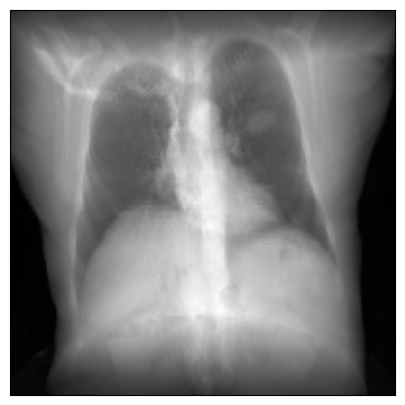

In [26]:
img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

## DRR Generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

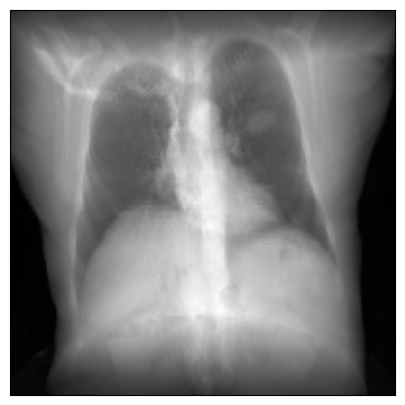

In [27]:
#| cuda
# Read in the volume and get the isocenter
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=300.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,  # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [28]:
# |cuda
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

7.03 s ± 585 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Sparse rendering

You can also render random sparse subsets of the pixels in a DRR.

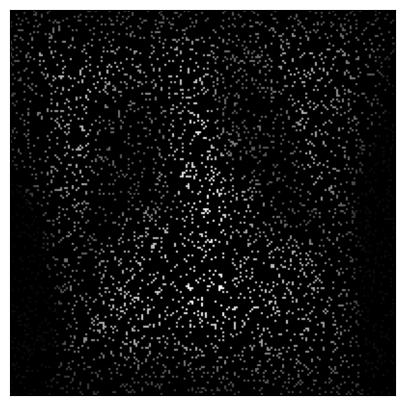

In [29]:
# |cuda
# Make the DRR with 10% of the pixels
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,  # Map rendered pixels back to their location in true space,
    # Useful for plotting, but can be disabled if using MSE as a loss function
).to(device)

# Make the DRR
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

In [14]:
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

675 ms ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Batched DRR synthesis

The tensors for `rotations` are expected to be of the size `[batch_size, c]`, where `c` is the number of components needed to represent the rotation (`3, 4, 6, 10`).
The tensors for `translations` are expected to be of the size `[batch_size, 3]`.

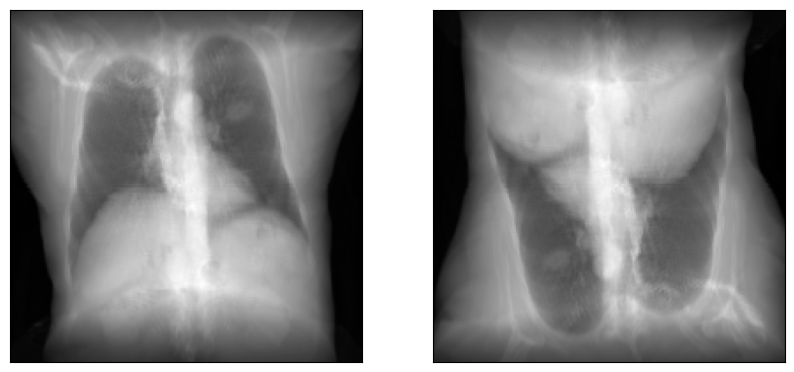

In [15]:
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
).to(device)

rotations = torch.tensor(
    [[torch.pi, 0.0, torch.pi / 2], [torch.pi, 0.0, -torch.pi / 2]], device=device
)
translations = torch.tensor([[bx, by, bz], [bx, by, bz]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

## Increasing DRR contrast

CT scans are easily segmented using Hounsfield units. We can use this to identify which voxels are air, soft tissue, or bone. By up or downweighting voxels corresponding to bones, we can change the contrast of generated DRRs.

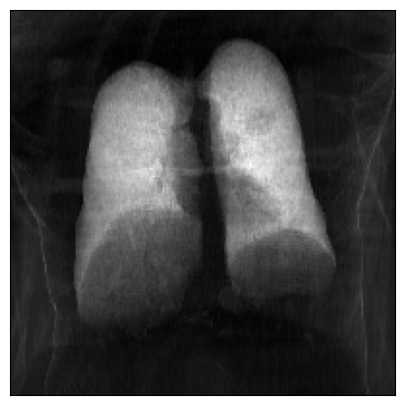

In [16]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
).to(device)

rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)

img = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
    bone_attenuation_multiplier=0.0,
)
plot_drr(img, ticks=False)
plt.show()